## DEPENDENCIES

In [ ]:
#!pip install scikit-surprise
# !pip install pyspark
!pip install git+https://github.com/gbolmier/funk-svd

# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q https://www-us.apache.org/dist/spark/spark-2.4.6/spark-2.4.6-bin-hadoop2.7.tgz
# !tar xf spark-2.4.6-bin-hadoop2.7.tgz

  Cloning https://github.com/gbolmier/funk-svd to /tmp/pip-req-build-0uxs9h4t
  Running command git clone -q https://github.com/gbolmier/funk-svd /tmp/pip-req-build-0uxs9h4t
  Created wheel for funk-svd: filename=funk_svd-0.0.1.dev1-cp36-none-any.whl size=8597 sha256=0894f6ebbacad0c1bb5ac116c1dc607b9220352e1c93f0480933ecb025084e8f
  Stored in directory: /tmp/pip-ephem-wheel-cache-fd2ii0ju/wheels/66/f1/cb/e8147525b73388cc0bd5588c915e731ab65aba9a968e3ba455
Successfully built funk-svd


In [ ]:
# spark
import os
import pyspark

# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/contnt/spark-2.4.6-bn-hadoop2.7"

# import findspark
# findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.sparkContext.setCheckpointDir('/content/drive/My Drive/thesis/checkpoint/')

from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.ml.feature import StringIndexer
from pyspark.sql.types import StructField, StructType, StringType, FloatType

# system
import sys
sys.path.append('/content/drive/My Drive/thesis')

# surprise library
from surprise import Reader, Dataset, dump
from surprise.model_selection import train_test_split, cross_validate, KFold
from surprise.accuracy import rmse, mae

# source
from util.util import precision_recall_at_k



In [ ]:
# dataframe and plotting
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns

%matplotlib inline
pd.plotting.register_matplotlib_converters()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### CONSTANTS

In [ ]:
# constant for consistent evaluation

# the answer of the universe
SEED = 42

# number of recommendation products
N_REC = 50

# traint set ratio
TEST_SIZE = 0.2

# num data
NROWS = 1000000

# number of K to compute precision and recall @k
K = 20
KS = range(5, 15, 5)

# threshold of a rating to be considered "relevant"
THRESHOLD = 3.0

# drive path
DRIVE_PATH = 'drive/My Drive/thesis'

### RECOMMENDER WRAPPER CLASS

In [ ]:
import numpy as np
import sys
sys.path.append('/content/drive/My Drive/thesis')

from util.util import precision_recall_at_k

from surprise import SVD, dump
from surprise.utils import get_rng
from surprise.model_selection import cross_validate

from collections import defaultdict

class Recommender:
    def __init__(self, model_path):
        # load prediction and model from a given file
        self.predictions, self.model = dump.load(model_path)
        self.user_ratings = defaultdict(set)

    def recommend(self, raw_uid, k=50, exclude_test=False):
        recommendations = []
        # get all the items from saved trainset
        for iid in self.model.trainset.all_items():
          if exclude_test:
            # if user has rated the product, skip it
            uid = self.model.trainset.to_inner_uid(raw_uid)
            if uid in self.user_ratings and iid in self.user_ratings[uid]:
              continue

          rid = self.model.trainset.to_raw_iid(iid)
          prediction = self.model.predict(raw_uid, rid)

          # only consider rating that are larger or equal than 3
          #if prediction.est >= 3:
          recommendations.append((rid, prediction.est))

        recommendations.sort(key=lambda x: x[1], reverse=True)
        return recommendations[:k]

    def map_user_rating(self):
      for uid, ratings in self.model.trainset.ur.items():
        self.user_ratings[uid] = set([r[0] for r in ratings])

    def get_neighbors(self, raw_id, user_based=False, k=50):
      """Returns Top-K neighbors of a user of item.
      Args:
          raw_id: User/item raw id
          k: Number of neighbors
      """
      if user_based:
          to_inner = self.model.trainset.to_inner_uid
          to_raw = self.model.trainset.to_raw_uid
      else:
          to_inner = self.model.trainset.to_inner_iid
          to_raw = self.model.trainset.to_raw_iid

      inner_id = to_inner(raw_id)
      inner_neighbors = self.model.get_neighbors(inner_id, k=k)

      raw_neighbors = [to_raw(iid) for iid in inner_neighbors]
  
      return raw_neighbors

    def get_short_head_and_long_tail_items(self, threshold):
        """Returns the short head and long tail items as a tuple.
        Args:
            threshold (int): If user's number of ratings larger than the threshold, it is in short-head.
             Else, it is in long-tail.
        """
        # using set for faster look-up time
        short_head_items = set()
        long_tail_items = set()


        for inner_iid, ratings in self.model.trainset.ir.items():
            raw_iid = self.model.trainset.to_raw_iid(inner_iid)
            if len(ratings) >= threshold:
                short_head_items.add(raw_iid)
            else:
                long_tail_items.add(raw_iid)

        return short_head_items, long_tail_items

    def compute_precision_recall_at_k(self, k=20, threshold=3):
      precisions, recalls = precision_recall_at_k(self.predictions, k=k, threshold=threshold)
      
      self.avg_precision = sum(prec for prec in precisions.values()) / len(precisions)
      self.avg_recall = sum(rec for rec in recalls.values()) / len(recalls)

      return self.avg_precision, self.avg_recall

    def compute_f1(self):
      return 2 * (self.avg_precision * self.avg_recall) / (self.avg_precision + self.avg_recall)

### NEW INCREMENTAL-SVD

In [ ]:
from funk_svd import SVD
from funk_svd.fast_methods import _run_epoch

class ISVD(SVD):
  def partial_fit(self, X):
    X = X.copy()

    u_ids = X['u_id'].unique().tolist()
    i_ids = X['i_id'].unique().tolist()

    n_user = len(self.user_dict)
    n_item = len(self.item_dict)
    n_new_user = 0
    n_new_item = 0

    for u_id in u_ids:
      if u_id not in self.user_dict:
        self.user_dict[u_id] = n_user
        n_user += 1
        n_new_user += 1

    for i_id in i_ids:
      if i_id not in self.item_dict:
        self.item_dict[i_id] = n_item
        n_item += 1
        n_new_item += 1

    X['u_id'] = X['u_id'].map(self.user_dict).astype(np.int32)
    X['i_id'] = X['i_id'].map(self.item_dict).astype(np.int32)

    # Start with the previous model
    pu = self.pu
    qi = self.qi
    bu = self.bu
    bi = self.bi

    X = X.values

    # Add rows for existed pu, qi, bu, bi
    pu_ = np.random.normal(0, .1, (n_new_user, self.n_factors))
    qi_ = np.random.normal(0, .1, (n_new_item, self.n_factors))
    bu_ = np.zeros(n_new_user)
    bi_ = np.zeros(n_new_item)

    pu = np.concatenate((pu, pu_))
    qi = np.concatenate((qi, qi_))
    bu = np.concatenate((bu, bu_))
    bi = np.concatenate((bi, bi_))

    # Run SGD for 1 epoch
    start = self._on_epoch_begin(0)
    pu, qi, bu, bi = _run_epoch(X, pu, qi, bu, bi, self.global_mean, self.n_factors, self.lr, self.reg)
    self._on_epoch_end(start)

    self.pu = pu
    self.qi = qi
    self.bu = bu
    self.bi = bi

import pickle 

def save_model(file_name, model=None, predictions=None, trainset=None):
  dump_obj = {
      'predictions': predictions,
      'model': model,
      'trainset': trainset,
  }
  pickle.dump(dump_obj, open(file_name, 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

def load_model(file_name):
  dump_obj = pickle.load(open(file_name, 'rb'))
  return dump_obj['model'], dump_obj['predictions'], dump_obj['trainset']

### PYSPARK HELPER FUNCTIONS

In [ ]:
def uid_to_ruid(df, uid):
  '''
  Convert user index to raw "reviewerID"
  '''
  user_row = df[df['reviewerID_index'].isin([uid])]

  if user_row.count():
    return user_row.collect()[0].reviewerID

  return False

def iid_to_riid(df, iid):
  '''
  Convert item index to "asin"
  '''
  item_row = df[df['asin_index'].isin([iid])]

  if item_row.count():
    return item_row.collect()[0].asin
  
  return False

def riid_to_iid(df, rid):
  item_row = df[df['asin'].isin([rid])] 

  if item_row.count():
    return item_row.collect()[0]['asin_index']

  return False

def ruid_to_uid(df, ruid):
  user_row = df[df['reviewerID'].isin([ruid])]

  if user_row.count():
    return user_row.collect()[0]['reviewerID_index']

  return False

def als_recommend(model, df, ruid, k=10):
  uid = ruid_to_uid(df, ruid)
  user_row = df.filter(df['reviewerID_index'] == uid).select('reviewerID_index').distinct()

  if user_row.count():
      rec_dict = model.recommendForUserSubset(user_row, k).collect()[0].asDict()['recommendations']
      rec_list = set()

      for rec in rec_dict:
        rec_list.add((iid_to_riid(df, rec[0]), rec[1]))
      
      return rec_list
      
  return False

def pyspark_precision_recall_at_k(predictions, k=10, threshold=3.0):
  precisions = dict()
  recalls = dict()

  for uid, user_ratings in predictions.items():
    # number of relevant items
    n_rel = sum((overall >= threshold) for (_, overall) in user_ratings)

    # number of recommended item in top K
    n_rec = sum((prediction >= threshold) for (prediction, _) in user_ratings[:k])

    # number of relevant and recommended in top K
    n_rel_and_rec = sum((overall >= threshold) and (prediction >= threshold) for (prediction, overall) in user_ratings[:k])

    # precision@k = proportion of recommended items that are relevant
    precisions[uid] = n_rel_and_rec / n_rec if n_rec != 0 else 1

    # recall@k = proportion of relevant items that are recommended
    recalls[uid] = n_rel_and_rec / n_rel if n_rel != 0 else 1

  als_precision = sum(prec for prec in precisions.values()) / len(precisions)
  als_recall = sum(rec for rec in recalls.values()) / len(recalls)
  als_f1 = 2 * (als_precision * als_recall) / (als_precision + als_recall)

  return als_precision, als_recall, als_f1

## DATA PRE-PROCESSING

### REMOVE NOISE 

In [ ]:
import pandas as pd
# Load data
ratings = pd.read_csv(DRIVE_PATH + '/data/ratings_score.csv', names=['user', 'item', 'overall', 'time'])
ratings.shape

(7824482, 4)

In [ ]:
ratings.drop(columns=['time'], axis=1, inplace=True)
ratings.plot(kind='hist')

In [ ]:
user_count = ratings.groupby('user').overall.count().reset_index().rename(columns={'overall': 'num_rating'})

In [ ]:
import numpy as np 
user_count.quantile(np.arange(0.9, 1, 0.01))

In [ ]:
def filter_noise(ratings, threshold=10):
  ratings_per_user = ratings.groupby('user').overall.count().reset_index().rename(columns={'overall': 'num_rating'})
  ratings_ = ratings.merge(ratings_per_user, on='user')
  cleaned_ratings = ratings_[ratings_.num_rating.astype('int') >= threshold]
  cleaned_ratings.drop(columns=['num_rating'], axis=1, inplace=True)

  return cleaned_ratings

In [ ]:
ratings_ = filter_noise(ratings, 50)
# ratings_.to_csv(DRIVE_PATH + '/data/final.csv', index=False)

In [ ]:
n_users_before = ratings['user'].nunique()
n_products_before = ratings['item'].nunique()

n_users = ratings_['user'].nunique()
n_products = ratings_['item'].nunique()

users_reduction_percentage = 1 - (n_users / n_users_before)
products_reduction_percentage = 1 - (n_products / n_products_before)

print(f'NUMBER OF USERS: {n_users} (was {n_users_before}) - a reduction of {users_reduction_percentage*100}%')
print(f'NUMBER OF PRODUCTS: {n_products} (was {n_products_before}) - a reduction of {products_reduction_percentage*100}%')
print(f'NUMBER OF RATINGS: {len(ratings_)} (was {len(ratings)})')

ratings_.plot(kind='hist')

If the data is pre-processed and saved in drive, load it.

In [ ]:
ratings = pd.read_csv(DRIVE_PATH + '/data/final.csv', header=0)

In [ ]:
ratings.head()

### SCIKIT-SURPRISE-BASED DATASET

In [ ]:
from sklearn.model_selection import train_test_split as tts
from surprise import Dataset, Reader, KNNWithMeans
import pandas as pd


# Load data.
df = pd.read_csv(DRIVE_PATH + '/data/final.csv', header=0)
df['timestamp'] = 0

# Split training and testing set.
train, test = tts(df, test_size=0.2, random_state=SEED)

data_reader = Dataset(Reader())
train_set = data_reader.construct_trainset(train.values)
test_set = data_reader.construct_testset(test.values)

surprise_df = Dataset.load_from_df(df.drop(columns=['timestamp']), Reader())
# train_set, test_set = train_test_split(surprise_df, test_size=0.2, random_state=SEED)
train.head()

,user,item,overall,timestamp
10563,AZMY6E8B52L2T,B00A1EQ950,5.0,0
122133,A2NN1KIYEM2SKS,B007FNF5IC,5.0,0
5431,A250AXLRBVYKB4,B001ISK6HK,4.0,0
27899,APQQK1V695AUE,B00015H0Z2,5.0,0
65166,A23NSKTMSPPBTR,B000068O3C,5.0,0


In [ ]:
len(train), len(test)

(100696, 25175)

### SPARK-BASED DATASET

In [ ]:
# Load from CSV and use StringIndexer to fit and transform on the raw data
schema = StructType([
    StructField("user", StringType()),
    StructField("item", StringType()),
    StructField("overall", FloatType())])
ps_raw_data = spark.read.load(DRIVE_PATH + '/data/final.csv', format='csv', header=True, schema=schema)

# index all columns except "overall"
indexer = [StringIndexer(inputCol=column, outputCol=column + "_index") for column in
               list(set(ps_raw_data.columns) - {'overall'})]

pipeline = Pipeline(stages=indexer)
ps_data = pipeline.fit(ps_raw_data).transform(ps_raw_data)

ps_train_set, ps_test_set  = ps_data.randomSplit([0.8, 0.2], seed=42)
ps_train_set.show()

### EXTRACT DATA FROM CONVERT JSON FOR DATABASE

Extract users' ratings


---



In [ ]:
# This block of code is used to read data from gzip.json file.

import pandas as pd
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

# get df from gzip file
def get_df(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import defaultdict

dataset = pd.read_csv(DRIVE_PATH +'/data/final.csv', header=0)
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=SEED)

ratings_dict = defaultdict(list)
for u_id, i_id, rating in train_set.values:
  ratings_dict[u_id].append((i_id, rating))
  
users_dict = []
for u_id, ratings in ratings_dict.items():
  raw_ratings = [{'asin': i_id, 'overall': rating} for i_id, rating in ratings]
  users_dict.append({'reviewerID': u_id, 'password': '$2b$10$oJXBsr2mAdjEnMPSE8jFxe952DPH5NVjGp5UoEFQ5vfrn0JprgRfG', 'ratings':raw_ratings})

In [ ]:
n_items = train_set['item'].nunique()
n_users = train_set['user'].nunique()

n_items, n_users

(41770, 1540)

In [ ]:
assert len(users_dict) == n_users

In [ ]:
# save 
import json

with open(DRIVE_PATH + '/data/users_final.json', 'w') as fout:
    json.dump(users_dict , fout)

Extract products' information


---



In [ ]:
# get full product information  
df = getDF(DRIVE_PATH + '/data/json_part/products_full.gz')

rated_products = set(train_set['item'].unique())
all_products = set(df['asin'].unique())
rated_products_df = df.query('asin in @rated_products').drop('salesRank', axis=1)
rated_products_df.head()

# save
rated_products_df.to_json(DRIVE_PATH + '/data/products_final.json', orient='records')

In [ ]:
assert len(rated_products_df) == n_items

Extract users' information


---



In [ ]:
df = getDF(DRIVE_PATH + '/data/json_part/ratings_with_text.json.gz')

rated_users = set(train_set['user'].unique())
rated_users_df = df.query('reviewerID in @rated_users')
rated_users_df.head()

# rated_users_df.to_json(FILE_PATH + '/data/reviews_final.json', orient='records')

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
9,A3BY5KCNQZXV5U,0594451647,Matenai,"[3, 3]",This product really works great but I found th...,5.0,This works great but read the details...,1390176000,"01 20, 2014"
15,AT09WGFUM934H,0594481813,John,"[0, 0]",It does 2A and charges a DEAD Nook in a few ho...,3.0,This is the oem charger you get with the nook hd+,1377907200,"08 31, 2013"
76,A3CLWR1UUZT6TG,0972683275,"FD Firefighter 121 ""Remember the 343""","[0, 0]",I have two of these now in different rooms. Wo...,5.0,Works well,1373587200,"07 12, 2013"
104,A3TAS1AG6FMBQW,0972683275,"Jeri Zerr ""formerly a Road Warrior of the Nth...","[0, 0]",The VideoSecu line of articulating wall mounts...,5.0,"High quality construction, comes with plenty o...",1353456000,"11 21, 2012"
189,A2Y4H3PXB07WQI,0972683275,Richard S. Sims,"[0, 0]","I have a 26"" LCD monitor mounted on unit.Seems...",4.0,Works as advertised.,1292457600,"12 16, 2010"


In [ ]:
len(train_set), len(rated_users_df)

(100696, 108465)

In [ ]:
# merge with the reviews dataframe to get the `reviewerName` column
users_df = pd.DataFrame(users_dict)
users_df.sort_values(by='reviewerID', ascending=False)

reviewer_name = rated_users_df.sort_values(by='reviewerID', ascending=False)[['reviewerID', 'reviewerName']].drop_duplicates()
users_with_name = users_df.merge(reviewer_name, on='reviewerID', how='outer').fillna('Amazon Customer').drop_duplicates(['reviewerID']).reset_index(drop=True)

# only get needed columns
users_with_name.columns = ['username', 'password', 'ratings', 'name']

# save
users_with_name.to_json(DRIVE_PATH + '/data/users_full_final.json', orient='records')

In [ ]:
assert len(users_with_name) == n_users

Extract review's full text

---






In [ ]:
# change column name and drop unnecessary columns
rated_users_df.rename(columns={'reviewerID':'username'}, inplace=True)
# rated_users_df.drop('reviewerName', axis=1, inplace=True)

# get all unique products and users
rated_products = set(train_set['item'].unique())
rated_users = set(train_set['user'].unique())

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
review_json = rated_users_df.query('(asin in @rated_products) & (username in @rated_users)').reset_index(drop=True)
review_json.to_json(DRIVE_PATH + '/data/reviews_final.json', orient='records')

## MODELING

### SCIKIT-SURPRISE MODELS

In [ ]:
import time
from collections import defaultdict
from surprise.model_selection import cross_validate
from surprise.accuracy import rmse, mae


def cross_validate_all(models, dataset):
  results = []

  for model_name, model in models:
    cv_results = cross_validate(model, dataset, n_jobs=-1)
    results.append((model_name, cv_results['test_rmse'].mean(), cv_results['test_mae'].mean()))

  return results

def train_and_test_all(models, train_set, test_set):
  results = []
  trained_models = []
  times = []
  for model_name, model in models:
    start = time.time()
    # train the model
    model.fit(train_set)
    # record the time it took
    end = time.time() - start

    predictions = model.test(test_set)

    results.append((model_name, end, rmse(predictions), mae(predictions)))
    trained_models.append((model, predictions))

  return results, trained_models, times

In [ ]:
from surprise import KNNWithMeans

models = [
          ('User-based KNN', KNNWithMeans(k=35, sim_options={'name': 'pearson', 'user_based':True,  'min_support':5})),
          ('Item-based KNN', KNNWithMeans(k=43, sim_options={'name': 'cosine', 'user_based':False,  'min_support':4})),
]

In [ ]:
cross_validate_all(models, surprise_df)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5), dpi=1000)
sns.barplot(x='Algorithm', y='Value', hue='Metric', data=cv_df_)

In [ ]:
rmse_and_mae, trained_models, times = train_and_test_all(models, train_set, test_set)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0317
MAE:  0.7713
Computing the cosine similarity matrix...


In [ ]:
rmse_and_mae

In [ ]:
# Save all the models.
user_based_knn, item_based_knn = trained_models

In [ ]:
from surprise import dump
dump.dump(file_name=DRIVE_PATH + '/model/u-knn', algo=user_based_knn[0], predictions=user_based_knn[1])
dump.dump(file_name=DRIVE_PATH + '/model/i-knn', algo=item_based_knn[0], predictions=item_based_knn[1])
# dump.dump(file_name=DRIVE_PATH + '/model/in-svd', algo=svd[0], predictions=svd[1])

### SPARK-BASED MODELS

In [ ]:
# create model
als = ALS(userCol='user_index', itemCol='item_index', ratingCol='overall', coldStartStrategy='drop', nonnegative=True)
als.setParams(maxIter=100, alpha=0.01, seed=SEED, intermediateStorageLevel='DISK_ONLY', checkpointInterval=2)

start = time.time()
# fit on train set
als_model = als.fit(ps_train_set)
end = time.time() - start

als_predictions = als_model.transform(ps_test_set)

# ALS model
evaluator = RegressionEvaluator(metricName='rmse', labelCol='overall', predictionCol='prediction')
als_rmse = evaluator.evaluate(als_predictions)

evaluator = RegressionEvaluator(metricName='mae', labelCol='overall', predictionCol='prediction')
als_mae = evaluator.evaluate(als_predictions)

# Append to final result
rmse_and_mae.append(('ALS', end, als_rmse, als_mae))

als_predictions.show()

In [ ]:
# Save model
als_model.save(DRIVE_PATH + '/model/als')

In [ ]:
# Save predictions
als_predictions.toPandas().to_csv(DRIVE_PATH + '/data/dataframe/ALS_preds.csv', index=False)

### INCREMENTAL SVD

In [ ]:
train_copy, test_copy = train.copy(), test.copy()
columns = ['u_id', 'i_id', 'rating', 'timestamp']
train_copy.columns = columns
test_copy.columns = columns

isvd = ISVD(learning_rate=.1, regularization=.02, n_epochs=50, n_factors=200)

In [ ]:
start = time.time()
isvd.fit(X=train_copy)
end = time.time() - start

from sklearn.metrics import mean_absolute_error, mean_squared_error

preds = isvd.predict(test_copy)
svd_mae = mean_absolute_error(test_copy['rating'], preds)
svd_rmse = np.sqrt(mean_squared_error(test_copy['rating'], preds))

In [ ]:
rmse_and_mae.append(('IncrementalSVD', end, svd_rmse, svd_mae))
rmse_and_mae

In [ ]:
# Turn predictions into dataframe and map with the test set
assert isvd.predict_pair(test_copy.iloc[0]['u_id'], test_copy.iloc[0]['i_id']) == preds[0]

test_copy['prediction'] = preds
test_copy.head()

In [ ]:
save_model(DRIVE_PATH + '/model/funk-svd', trainset=train_copy, model=isvd, predictions=test_copy.drop(columns='timestamp'))

## LOAD ALL MODELS

In [ ]:
# Load models
uknn_recsys = Recommender(DRIVE_PATH + '/model/u-knn')
iknn_recsys = Recommender(DRIVE_PATH + '/model/i-knn')

In [ ]:
als_recsys = ALSModel.load(DRIVE_PATH + '/model/als')

## XQUAD ON TOP-N RECOMMENDATION

### THE ALGORITHM

In [ ]:
def xquad(recommendation, user_profile, short_items, long_items, trainset, n_epochs=10, reg=.35, binary=False):
  # In case there are not enough items in the recommendation list
  n_epochs = min(len(recommendation), n_epochs)
  
  final_result = []
  S = []

  # In order to select the next item to add to S,
  # we compute a score for each item in R\S (in R not in S)
  for n in range(n_epochs):
    # For selecting the best score
    best_score = 0
    best_item = None

    for r in recommendation:
      v = r[0]
      p_vu = r[1]

      # v already in S, so skip it.
      if v in S:
        continue

      p_vu = (p_vu - 1.0) / (5.0 - 1.0)
      score = (1 - reg)*(p_vu)

      summation = 0

      for d in (short_items, long_items):
        # Because P(v|c)is 0 if `v` not in category `d`
        if v not in d:
          summation += 0
          continue

        # The ratio of items in the user profile which belong to category `d`
        p_du = sum([item in d for item in user_profile]) / len(user_profile)
        
        # Binary - equals to 1 when item `i` in list `S` already covers category `d`, 0 otherwise
        if binary:
          p_id_s = 1 if any([i in d for i in S]) else 0
        else:
          # Smooth - the ratio of items in list `S` that covers category `d`
          p_id_s = sum([i in d for i in S]) / len(S) if len(S) > 0 else 0
        
        # pi = (1 - P(i|d, S))
        pi = 1 - p_id_s

        summation += p_du * pi

      score += reg * summation

      if score > best_score:
        best_score = score
        best_item = v
      
    S.append(best_item)
    final_result.append((best_item, best_score))
    
  return tuple(final_result)

In [ ]:
def re_rank(recommend_list, user_profile, short_head_items, long_tail_items, train_set, n_epochs=10, reg=.35, binary=False):
  """Returns the re-ranked recommendation list for a user using XQuAD method.
    See Also:
        https://www.researchgate.net/publication/330576544_Managing_Popularity_Bias_in_Recommender_Systems_with_Personalized_Re-ranking
    Args:
        recommend_list (list): The recommended products list generated by the base algorithm.
        user_profile (list): The user's ratings.
        short_head_items (list): The items that are in the short-head area.
        long_tail_items (list): The items that are in the long-tail area.
        train_set (object): The dataset that is used for training.
        n_epochs (int): Number of epochs is equal to the number of items in the recommendation list. 
        reg (float): The regularization parameter for xQuAD method. 
        binary (bool): If True, the Binary xQuAD is used. Otherwise, the Smooth xQuAD is used.
  """
  # for user that does not have enough rating to finish full n_epochs
  num_recommends = len(recommend_list)
  n_epochs = min(num_recommends, n_epochs)

  S = []
  scores = []

  for _ in range(n_epochs):
    best_score = -float('inf')
    best_item = None

    for rec in recommend_list:
      # current item's id
      v = rec[0]

      if v in S:
        continue

      # item's predicted rating
      p_vu = (rec[1] - 1.0) / (5.0 - 1.0)
      # p_vu = rec[1]
      score = (1 - reg) * p_vu
      summation = 0

      # for each category
      for c in (short_head_items, long_tail_items):
        # how much user is interested in short head items versus long tail items
        # p_cu = sum((train_set.to_raw_iid(r[0]) in c for r in user_profile)) / len(user_profile)
        p_cu = sum((u_id in c for u_id in user_profile)) / len(user_profile)

        if binary:
          # if item `i` in list `S` cover category `c`, then `p_ic_s` = 1, otherwise 0 (Binary xQuAD)
          # this means, if the current items in `S` have not covered the category `c`, the term equals to 1
          p_ic_s = 1 if all([i not in c for i in S]) else 0
        else:
          # ratio of items in list `S that covers category `c` (Smooth xQuAD)
          len_s = len(S)
          p_ic_s = 1 - (sum([i in c for i in S]) / len_s if len_s != 0 else 0)

        # 1 if item in `c`, otherwise 0
        p_vc = 1 if v in c else 0
        summation += p_cu * p_vc * p_ic_s
    
      score += reg * summation
      # print(v, v in short_head_items, v in long_tail_items, score, S)
      
      
      if score > best_score:
        best_score = score
        best_item = v
    # print('='*50)
    scores.append(best_score)
    S.append(best_item)
    
  return tuple(zip(S, scores))

In [ ]:
from math import log

def arp(recommend_list, trainset, testset):
  u_t = len(set([u for u, _, _ in testset]))
  all_items = trainset.groupby(by='i_id').count()['rating'].to_dict()
  popularity = 0

  for _, l_u in recommend_list.items():
    num_recommends = len(l_u)
    total_rates = 0
    for i, _ in l_u:
      try:
        times_rated = all_items[i]
      except:
        times_rated = 0
      total_rates += times_rated
    popularity += (total_rates / num_recommends)
  
  return popularity / u_t

def aplt(recommend_list, testset, long_tail_items):
  u_t = len(set([u for u, _, _ in testset]))

  long_tail_ratio = 0
  # l_u is user recommended list
  for _, l_u in recommend_list.items():
    long_tail_ratio += sum((i in long_tail_items for i, _ in l_u)) / len(l_u)
    
  return long_tail_ratio / u_t

def catalog_coverage(recommend_list, testset, long_tail_items):
  u_t = len(set([u for u, _, _ in testset]))

  # item_set = set()
  # coverage = 0
  # for u, l_u in recommend_list.items():
  #   for i, _ in l_u:
  #     if i not in item_set and i in long_tail_items:
  #       item_set.add(i)
  #       coverage += 1

  unique = set([i for _, l_u in recommend_list.items() for i, _ in l_u])
  n_in_longtail = len([i in long_tail_items for i in unique])
  coverage = n_in_longtail / len(long_tail_items)

  return coverage
  # return round(coverage / u_t, decimal)

def dcg_at_k(scores, k=None):
  assert scores

  if k is None:
    k = len(scores) + 1

  return scores[0] + sum(sc / log(ind, 2) for sc, ind in zip(scores[1:], range(2, k)))

def ndcg_at_k(predicted_scores, actual_scores, k=None):
  assert len(predicted_scores) == len(actual_scores)
  if k is None:
    k = len(actual_scores) + 1

  idcg = dcg_at_k(sorted(actual_scores, reverse=True), k=k)
  
  return (dcg_at_k(predicted_scores) / idcg) if idcg > 0.0 else 0.0

def to_relevance_map(predicted_scores, actual_scores):
  assert len(predicted_scores) == len(actual_scores), 'Predicted labels length is different from actual labels'
  
  predicted_scores = sorted(predicted_scores, key=lambda x: x[1], reverse=True)
  # # if rating score >= 3, the item is relevant
  actual_items = set([i for i, r_ui in actual_scores if r_ui >= 3.0])

  # if item in test set, it is relevant
  # actual_items = set([i for i, _ in actual_scores])
  relevance_map = [1 if i in actual_items else 0 for i, _ in predicted_scores]

  return relevance_map

def average_ndcg_at_k(predicted_scores, actual_scores, k=None):
  assert len(predicted_scores) == len(actual_scores)
  ndcg_scores = []
  
  for i in predicted_scores.keys():
    if k is None:
      k = len(actual_scores) + 1
    
    predicted_relevance = to_relevance_map(predicted_scores[i], actual_scores[i])
    true_relevance = [1 if r_ui >= 3.0 else 0 for _, r_ui in actual_scores[i]]

    ndcg_scores.append(ndcg_at_k(predicted_relevance, true_relevance, k=k))

  return np.mean(ndcg_scores)

from collections import defaultdict
def precision_recall(recommend_list, testset, k=10, threshold=3.0):
  user_est_true = defaultdict(list)
  for u_id, i_id, rating in testset:
    user_est_true[u_id].append((i_id, rating))
  
  rel = ((i_id, rating) for (i_id, rating) in user_ratings if rating >= threshold)
  rec = 



def get_score(recommend_list, trainset, testset, long_tail_items, last_score, ideal_top_n):
  arp_score = arp(recommend_list, trainset, testset)
  print(f'ARP score: {arp_score} ({arp_score - last_score[0]})')

  aplt_score = aplt(recommend_list, testset, long_tail_items)
  print(f'APLT score: {aplt_score} ({aplt_score - last_score[1]})')

  cc = catalog_coverage(recommend_list, testset, long_tail_items)
  print(f'Catalog Coverage score: {cc} ({cc - last_score[2]})')
  
  ndcg_score = average_ndcg_at_k(recommend_list, ideal_top_n)
  print(f'NDCG score: {ndcg_score} ({ndcg_score - last_score[3]})')

  precisions, recall = precision_recall_at_k(recommend_list, k=10)
  avg_precision = sum(prec for prec in precisions.values()) / len(precisions)
  avg_recall = sum(rec for rec in recalls.values()) / len(recalls)


  return arp_score, aplt_score , cc, ndcg_score, avg_precision, avg_recall

### REC-SYS FOR INCREMENTAL SVD

In [ ]:
import pandas as pd
from collections import defaultdict

class RecSys:
  def __init__(self, model_path):
    self.model, self.predictions, self.trainset = load_model(model_path)
  
  
  def recommend(self, u_id, n=50, exclude_test=True):
    # Get all products
    all_items = self.get_full_dataset()['i_id'].unique()
    user_profile = set(self.get_user_profile(u_id))

    # Predict the user rating on each product
    recommendations = []
    for i_id in all_items:
      if exclude_test and i_id in user_profile:
        continue
      prediction = self.model.predict_pair(u_id, i_id)
      recommendations.append((i_id, prediction))

    # # Get all products
    # all_items = self.get_full_dataset()['i_id'].unique()

    # # Predict the user rating on each product
    # recommendations = []
    # for i_id in all_items:
    #   prediction = self.model.predict_pair(u_id, i_id)
    #   recommendations.append((i_id, prediction))

    recommendations.sort(key=lambda x: x[1], reverse=True)
    return recommendations[:n]
    

  def get_full_dataset(self):
    return pd.concat([self.trainset, self.predictions.drop(columns=['prediction'])]).drop(columns=['timestamp'])

  def get_testset(self):
    return self.predictions.drop(columns=['prediction'])

  def get_top_n(self, n=10):
    # Get top n recommendation from test set
    top_n = defaultdict(list)
    for uid, iid, true_r, est in self.predictions.values:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

  def get_ideal_top_n(self, n=10):
    ideal_top_n = defaultdict(list)

    for raw_uid, raw_iid, overall, _ in self.predictions.values:
      ideal_top_n[raw_uid].append((raw_iid, overall))

    for raw_uid, user_ratings in ideal_top_n.items():
      user_ratings.sort(key=lambda x: x[1], reverse=True)
      ideal_top_n[raw_uid] = user_ratings[:n]

    return ideal_top_n
    
  def get_short_head_and_long_tail_items(self, threshold):
    """Returns the short head and long tail items as a tuple.
    Args:
        threshold (int): If user's number of ratings larger than the threshold, it is in short-head.
          Else, it is in long-tail.
    """
    # using set for faster look-up time
    dataset = self.get_full_dataset()
    data_items = dataset.groupby(by='i_id').count().reset_index()

    short_head_items = set(data_items[data_items['rating'] >= threshold]['i_id'].values)
    long_tail_items = set(data_items[data_items['rating'] < threshold]['i_id'].values)

    self.short_head = short_head_items
    self.long_tail = long_tail_items

    return short_head_items, long_tail_items

  def get_user_profile(self, u_id):
    return self.trainset[self.trainset['u_id'] == u_id]['i_id'].unique()

In [ ]:
svd_recsys = RecSys(DRIVE_PATH + '/model/funk-svd') 

### SOME TESTS


Making sure the metrics are legit.

In [ ]:
# All long tail items
svd_recsys = RecSys(DRIVE_PATH + '/model/funk-svd')
short_items, long_items = svd_recsys.get_short_head_and_long_tail_items(20)
trainset = svd_recsys.trainset
testset = svd_recsys.predictions.drop(columns='prediction').values
recommend_list_a = defaultdict(list)
recommend_list_a['a'] = [('0972683275', 5.0), ('B00BT0IVRO', 5.0), ('B007BGFNBM', 5.0)]

arp_a = arp(recommend_list_a, trainset, testset)
aplt_a = aplt(recommend_list_a, testset, long_items)
aclt_a = aclt(recommend_list_a, testset, long_items)

In [ ]:
# All short head items
trainset = svd_recsys.trainset
testset = svd_recsys.predictions.drop(columns='prediction').values
recommend_list_b = defaultdict(list)
recommend_list_b['a'] = [('B00K91DB7Y', 5.0), ('B00JP12170', 5.0), ('B00JF0D7RE', 5.0)]

arp_b = arp(recommend_list_b, trainset, testset)
aplt_b = aplt(recommend_list_b, testset, long_items)
aclt_b = aclt(recommend_list_b, testset, long_items)

Average Popularity **(ARP)** of all short-head recommendations **should be than bigger** all long-tail recommendations. In the other hand, average coverage and percentage of long-tail items **(APLT, ACLT)** of all short-head recomemndations **should be smaller** than all long-tail recommendations. 

In [ ]:
assert arp_a <= arp_b
assert aplt_a >= aplt_b and aclt_a >= aclt_a



---



Let's use the algorithm to re-rank a user's 
recommendations in test set.




In [ ]:
ratings = pd.read_csv(DRIVE_PATH + '/data/final.csv', header=0)
dataset = ratings.groupby(by='item').count().reset_index()
short_head_items = set(dataset[dataset['overall'] >= 20]['item'].values)
long_tail_items = set(dataset[dataset['overall'] < 20]['item'].values)

top_20 = svd_recsys.get_top_n(n=20)

top_20_ = []
for i_id, rating in top_20['A2XU6J41ZQOJ2V']:
  in_long_tail = i_id in long_tail_items
  in_short_head = i_id in short_head_items
  top_20_.append((i_id, rating, in_short_head, in_long_tail))

top_20_true = []
for i_id, rating, in_short, in_long in top_20_:
  if i_id == 'B000LRMS66' or i_id == 'B004WK3U9W':
    continue

  top_20_true.append((i_id, rating, in_short, in_long))

top_20_true

In [ ]:
xquad(top_20_true, svd_recsys.get_user_profile('A2XU6J41ZQOJ2V'), short_head_items, long_tail_items, svd_recsys.trainset, binary=True, reg=0.9)

In [ ]:
re_rank(top_20_true, svd_recsys.get_user_profile('A2XU6J41ZQOJ2V'), short_head_items, long_tail_items, svd_recsys.trainset, binary=True, reg=0.9)

---

### Some stats on popularity


In [ ]:
testset = svd_recsys.predictions.drop(columns='prediction')
trainset = svd_recsys.trainset
dataset = pd.concat([testset, trainset]).drop(columns=['timestamp'])

In [ ]:
testset_by_item = testset.groupby(by='i_id').count()
testset_by_user = testset.groupby(by='u_id').count()

In [ ]:
ideal_top_10 = svd_recsys.get_ideal_top_n(n=10)
short_items, long_items = svd_recsys.get_short_head_and_long_tail_items(threshold=3)

In [ ]:
predicted_scores = svd_recsys.predictions['prediction'].values.tolist()
actual_scores = svd_recsys.predictions['rating'].values.tolist()

ndcg_at_k(predicted_scores, actual_scores)

0.9845038566012624

In [ ]:
ideal_top_10['A2XU6J41ZQOJ2V']

[('B004BDOREC', 5.0),
 ('B0000CD08M', 5.0),
 ('B003L62T7W', 5.0),
 ('B000LRMS66', 5.0),
 ('B002ZIN9DU', 5.0),
 ('B000BGZMSI', 5.0),
 ('B004WK3U9W', 5.0),
 ('B00687VH2Y', 5.0),
 ('B0007MXZB2', 5.0),
 ('B002Q0W80C', 5.0)]

In [ ]:
in_short_head = []
in_long_tail = []
for u_id, ratings in ideal_top_10.items():
  in_short = sum((i_id in short_items for i_id, rating in ratings)) / len(ratings)
  in_long = sum((i_id in long_items for i_id, rating in ratings)) / len(ratings)
  in_short_head.append(in_short)
  in_long_tail.append(in_long)

np.mean(in_short_head), np.mean(in_long_tail)

(0.635009534116677, 0.364990465883323)

In [ ]:
dataset = pd.concat([svd_recsys.trainset, svd_recsys.predictions.drop(columns=['prediction'])]).drop(columns=['timestamp'])
data_count = dataset.groupby(by='i_id').count()
dataset.groupby(by='i_id').count().quantile(np.arange(0.63, 1.0, 0.001))

,u_id,rating
0.630,1.000,1.000
0.631,1.000,1.000
0.632,1.000,1.000
0.633,1.000,1.000
0.634,1.000,1.000
...,...,...
0.995,30.000,30.000
0.996,33.000,33.000
0.997,39.000,39.000
0.998,46.000,46.000


In [ ]:
short_items, long_items = svd_recsys.get_short_head_and_long_tail_items(3)
item_list = dataset['i_id'].values.tolist()
dataset['in_short'] = [i in short_items for i in item_list]
dataset['in_long'] = [i in long_items for i in item_list]

### Smooth and Binary XQuAD

**Start here**


---



In [ ]:
svd_recsys = RecSys(DRIVE_PATH + '/model/funk-svd') 

In [ ]:
top_10_recommend = svd_recsys.get_top_n(n=10)
top_50_recommend = svd_recsys.get_top_n(n=50)
ideal_top_10 = svd_recsys.get_ideal_top_n(n=10)

short_items, long_items = svd_recsys.get_short_head_and_long_tail_items(threshold=3)
print(len(short_items), len(long_items))

10380 37810


In [ ]:
import numpy as np

def test_xquad(recsys, top_n_recommend, ideal_top_n, binary=False, reg_range=None, short_items=None, long_items=None, threshold=20):
  if reg_range is None:
    reg_range = np.arange(0.0, 1.0, 0.1)
  
  if short_items is None or long_items is None:
    short_items, long_items = recsys.get_short_head_and_long_tail_items(threshold=threshold)
  
  n_items = len(short_items) + len(long_items)
  print(f'Percentage of short-head: {100*len(short_items)/n_items}%; Percentage of long-tail: {100*len(long_items)/n_items}%')
  print('*'*20)
  algo_name = 'binary' if binary else 'smooth'
  train_set = recsys.trainset
  test_set = recsys.predictions.drop(columns='prediction').values
  scores = []
  last_score = [0, 0, 0, 0]
  for reg in reg_range:
    print(f'Testing XQuAD on {reg}:')
    ranked_top_n = defaultdict(list)

    for u_id, recommend_list in top_n_recommend.items():
      user_profile = recsys.get_user_profile(u_id)
      ranked_top_n[u_id] = xquad(recommend_list, user_profile, short_items, long_items, train_set, reg=reg, binary=binary)

    print('Done applying XQuAD on the recommendation list.')
    print('Evaluating the result...')
    
    last_score = arp, aplt, cc, ndcg = get_score(ranked_top_n, train_set, test_set, long_items, last_score, ideal_top_n)
    print('='*20)
    scores.append((reg, arp, aplt, cc, ndcg, algo_name))
  
  return scores

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_xquad(smooth_scores, binary_scores):
  columns = ['reg', 'ARP', 'APLT','Catalog Coverage', 'NDCG', 'type']
  xquad_df = pd.DataFrame(smooth_scores + binary_scores, columns=columns)
  xquad_df['reg'] = xquad_df['reg'].apply(lambda x: round(x, 3))
  
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))
  plt.figure(dpi=1000)
  # plt.subplots_adjust(right=10, top=5, left=5)
          
  sns.lineplot(x='reg', y='APLT', hue='type', style='type', markers=['o','v'], data=xquad_df, ax=ax1, markersize=14)
  sns.lineplot(x='reg', y='Catalog Coverage', hue='type', style='type', markers=['o','v'], data=xquad_df, ax=ax2, markersize=14)
  sns.lineplot(x='reg',y='ARP', hue='type', style='type', markers=['o','v'], data=xquad_df, ax=ax3, markersize=14)
  for ax in (ax1, ax2, ax3):
    handles, labels = ax.get_legend_handles_labels()
    # ax.legend(handles=handles[1:], labels=labels[1:])
    ax.legend().remove()
    ax.grid(True, linestyle='--')
    ax.set_xticks(xquad_df['reg']) 
    ax.set_xticklabels(xquad_df['reg'], fontsize=12)
    ax.set_xlabel('$\lambda$')
    ax.yaxis.label.set_size(14)
    ax.xaxis.label.set_size(14)
  
  fig.legend(handles=handles[1:], labels=labels[1:], loc='upper center')
  
  return xquad_df

In [ ]:
smooth_scores = test_xquad(svd_recsys, top_50_recommend, ideal_top_10, threshold=3)
print('>'*50)
binary_scores = test_xquad(svd_recsys, top_50_recommend, ideal_top_10, binary=True, threshold=3)

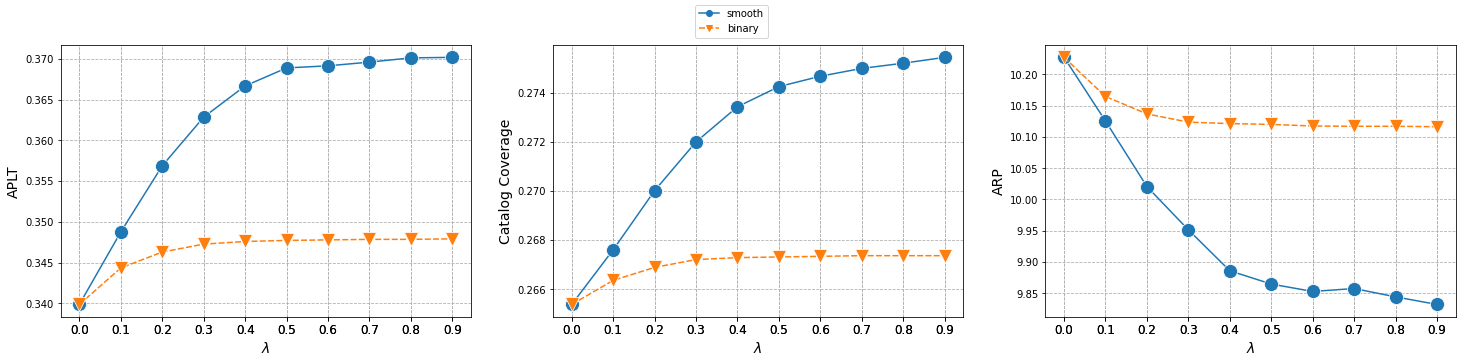

<Figure size 6000x4000 with 0 Axes>

In [ ]:
xquad_df_3= plot_xquad(smooth_scores, binary_scores)

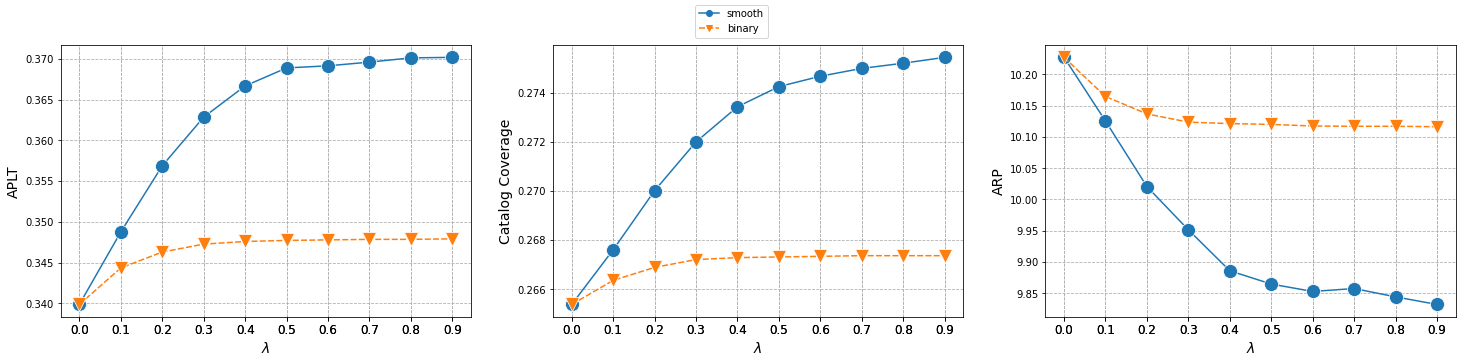

<Figure size 6000x4000 with 0 Axes>

In [ ]:
xquad_df_3 = plot_xquad(smooth_scores, binary_scores)
xquad_df_3.to_csv(DRIVE_PATH + '/data/dataframe/XQuAD_3.csv', index=False)

In [ ]:
binary_scores_4 = test_xquad(svd_recsys, top_50_recommend, ideal_top_10, binary=True, threshold=2) 
print('>'*50)
smooth_scores_4 = test_xquad(svd_recsys, top_50_recommend, ideal_top_10, threshold=2)

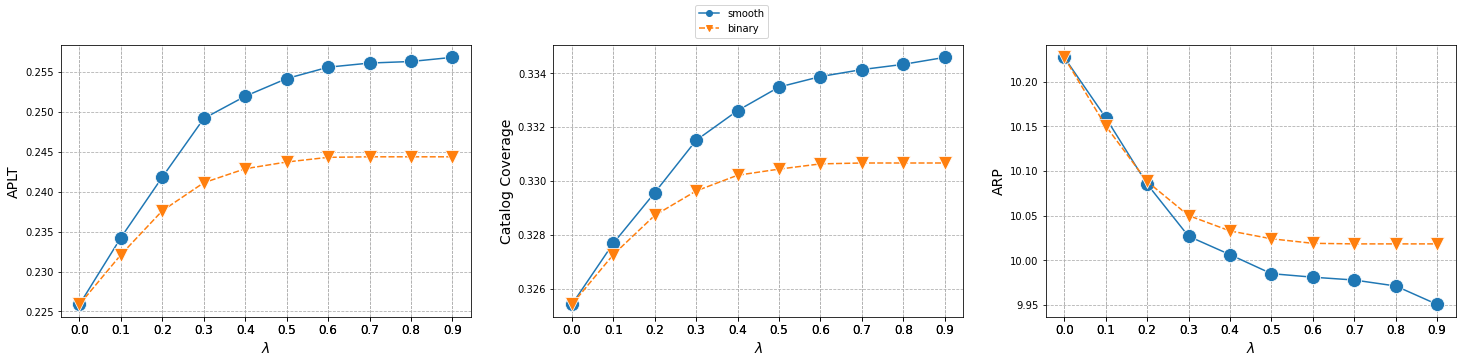

<Figure size 6000x4000 with 0 Axes>

In [ ]:
xquad_df_4 = plot_xquad(smooth_scores_4, binary_scores_4)
xquad_df_4.to_csv(DRIVE_PATH + '/data/dataframe/XQuAD_4.csv', index=False)

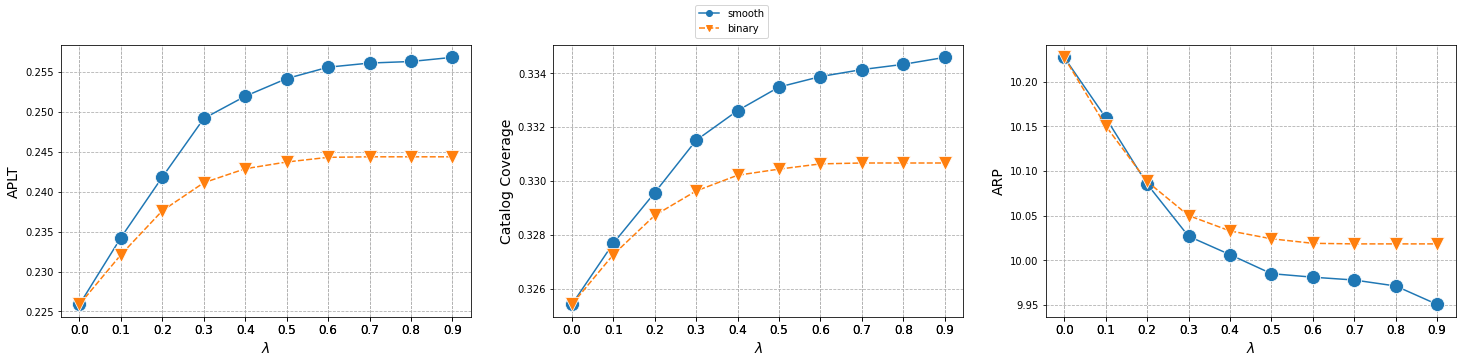

<Figure size 6000x4000 with 0 Axes>

In [ ]:
# binary_scores_5 = test_xquad(svd_recsys, top_50_recommend, ideal_top_10, binary=True, threshold=2) 
# print('>'*50)
# smooth_scores_5 = test_xquad(svd_recsys, top_50_recommend, ideal_top_10, threshold=2)

xquad_df_5 = plot_xquad(smooth_scores_5, binary_scores_5)

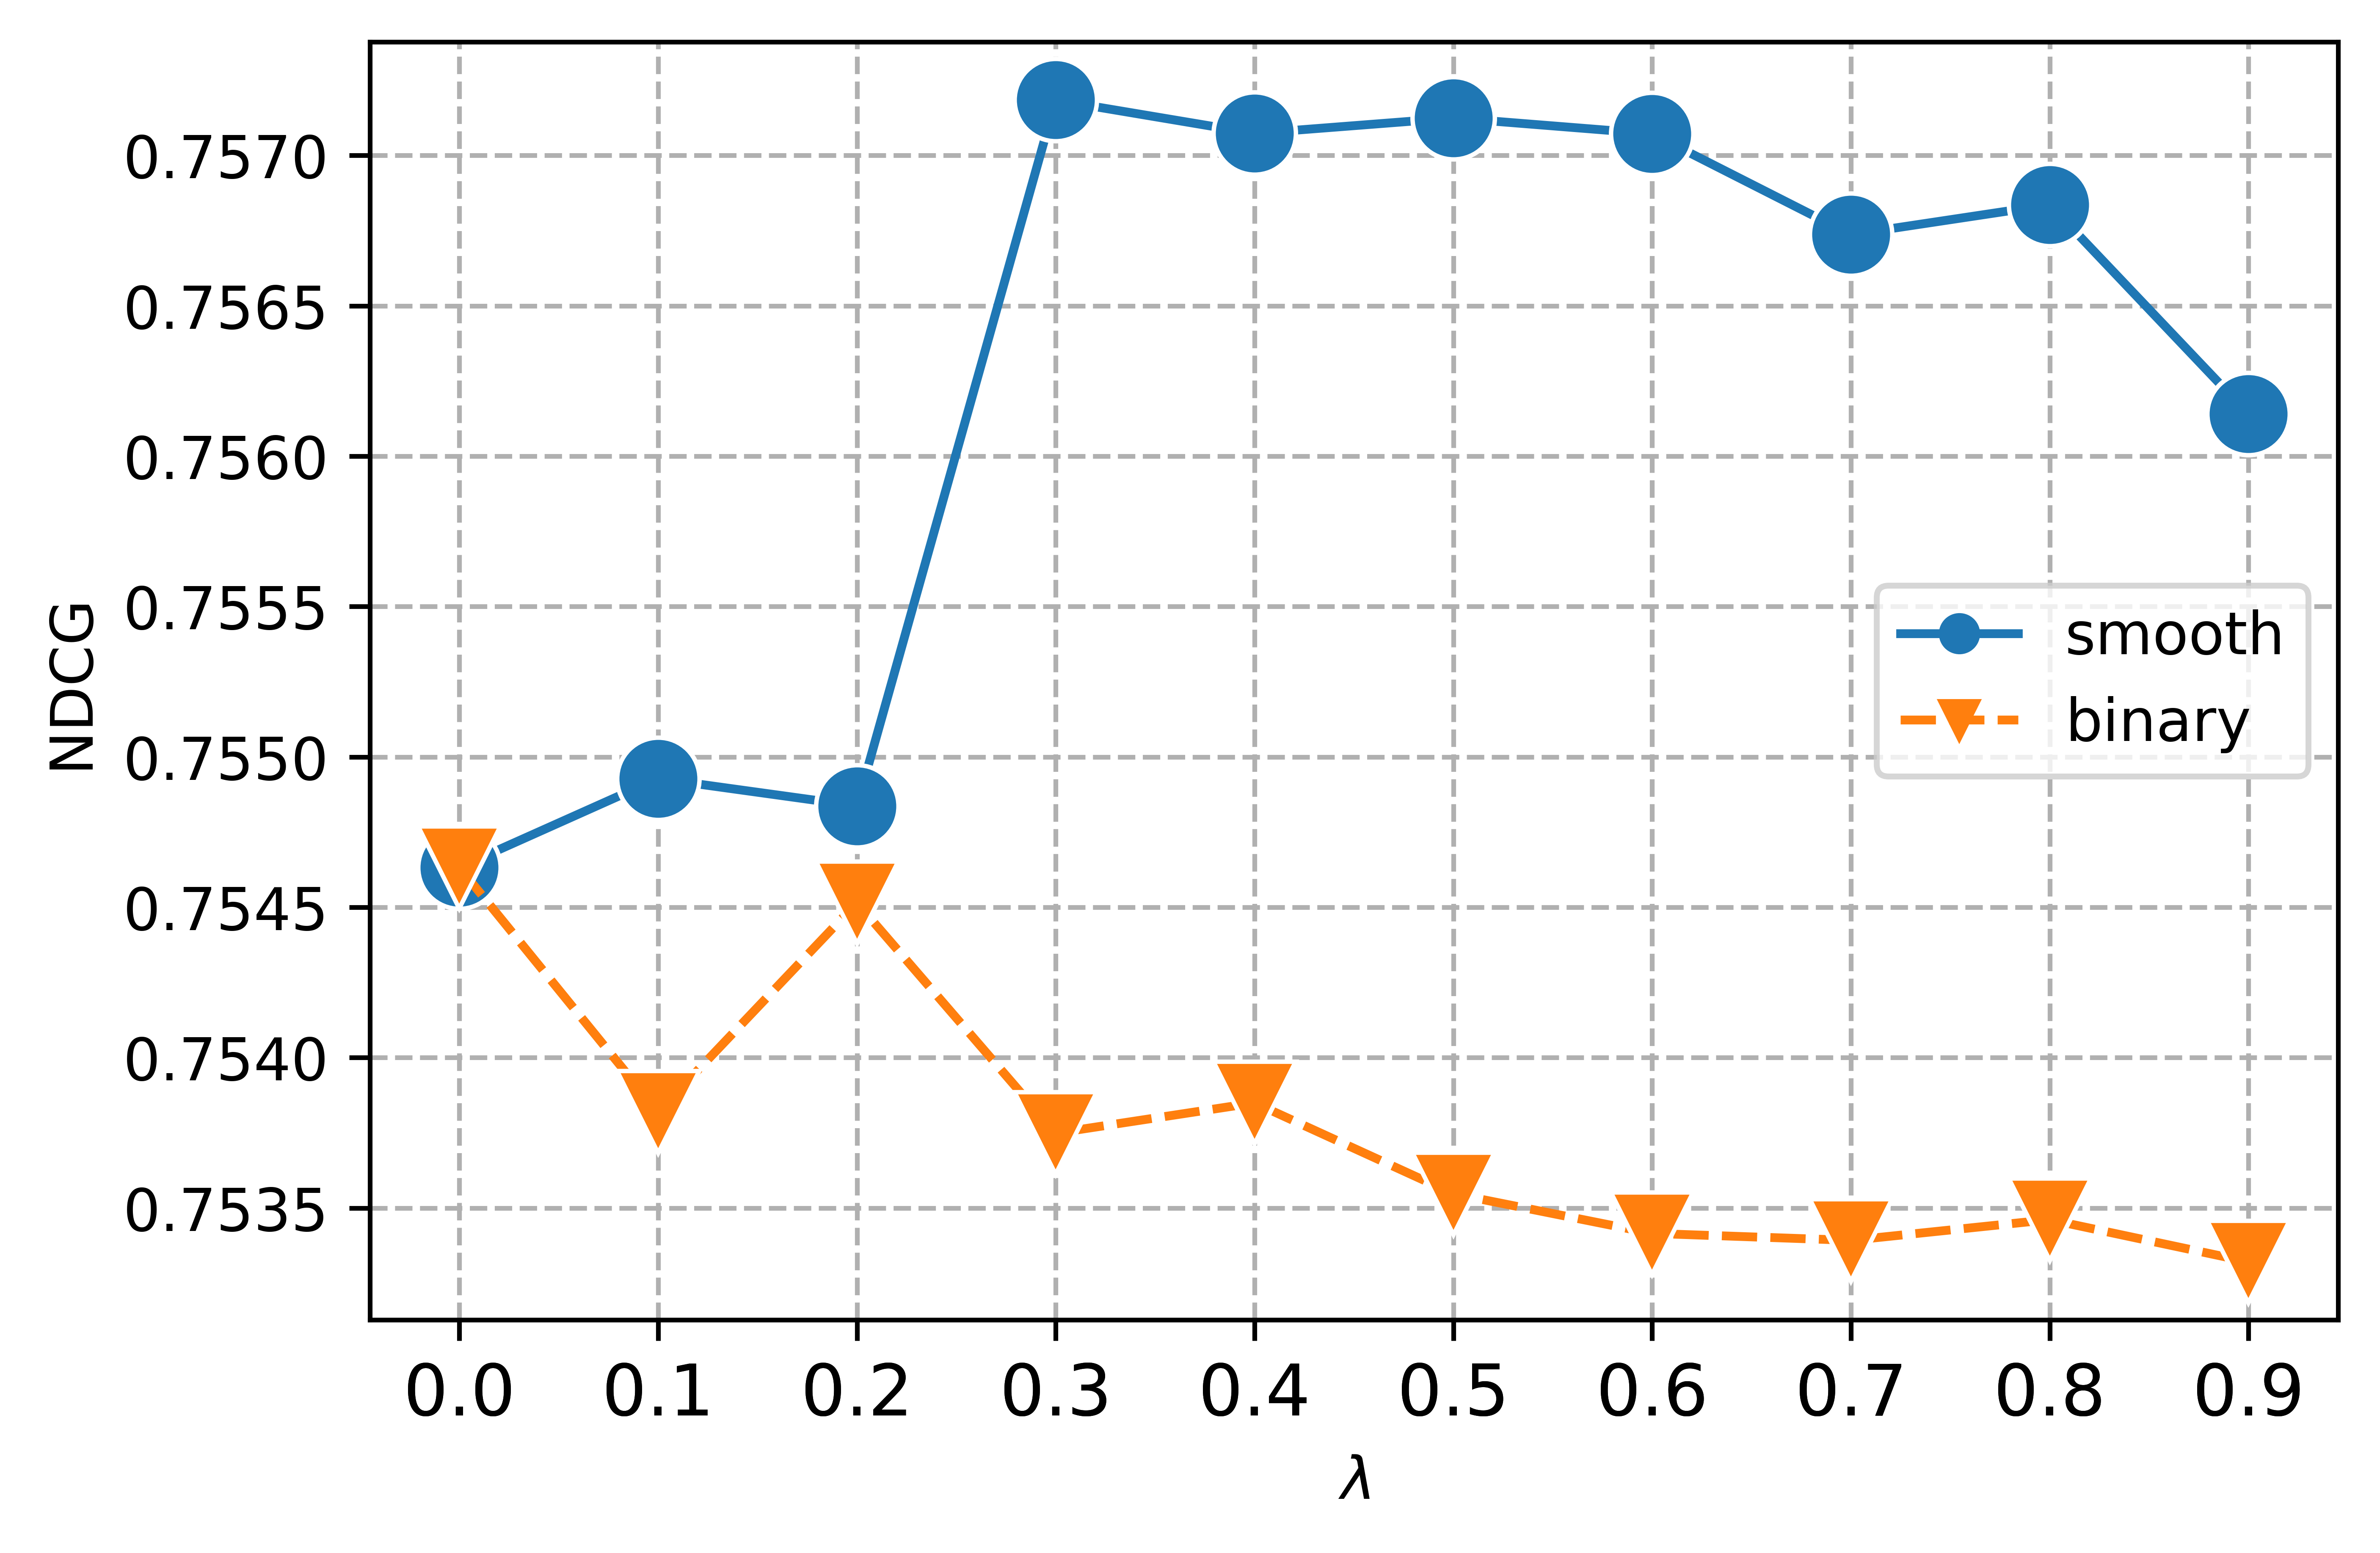

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

xquad_df = xquad_df_3.copy()
plt.figure(dpi=1000)
ax = plt.gca()

p = sns.lineplot(x='reg',y='NDCG', hue='type', style='type', markers=['o','v'], data=xquad_df, markersize=14)
handles, labels = ax.get_legend_handles_labels()
ax.set_xlabel('$\lambda$')
ax.set_xticks(xquad_df['reg']) 
ax.set_xticklabels(xquad_df['reg'], fontsize=12)
ax.legend(handles=handles[1:], labels=labels[1:], loc='center right')
ax.grid(True, linestyle='--')

p.get_figure().savefig('NDCG', dpi=500)



---



In [ ]:
from collections import defaultdict
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

def get_ideal_top_n(test_set, n=10):
  ideal_top_n = defaultdict(list)

  for raw_uid, raw_iid, overall, _ in test_set:
    ideal_top_n[raw_uid].append((raw_iid, overall))

  for raw_uid, user_ratings in ideal_top_n.items():
    user_ratings.sort(key=lambda x: x[1], reverse=True)
    ideal_top_n[raw_uid] = user_ratings[:n]

  return ideal_top_n
    
def get_score(recommend_list, trainset, testset, long_tail_items):
  return arp(recommend_list, trainset, testset), aplt(recommend_list, trainset, testset, long_tail_items), aclt(recommend_list, trainset, testset, long_tail_items)

From a recommendation list of *maximum* **50 products**, use the **xQuAD** algorithm to produce a recommendation list of *maximum* **10 products**.

Some measures are used to measure the change of the popularity and amount of long-tail items in the recommendation list.

**Note: the ideal ranking for NDCG@K is the user ratings in the test set sorted descending by the rating score.*

In [ ]:
scores = []

# First Smooth xQuAD
for reg in np.arange(0.1, 1.0, 0.1):
  ranked_top_n = defaultdict(list)

  for raw_uid, recommend_list in top_50_recommend.items():
    inner_uid = train_set.to_inner_uid(raw_uid)
    user_profile = train_set.ur[inner_uid]
    ranked_top_n[raw_uid] = re_rank(recommend_list, user_profile, short_items, long_items, train_set, reg=reg)
    
  ndcg = average_ndcg_at_k(ranked_top_n, ideal_top_10)
  score = get_score(ranked_top_n, train_set, test_set, long_items)
  scores.append((reg, score[0], score[1], score[2], ndcg, 'smooth')) 

  print(reg, score, ndcg)

In [ ]:
for reg in np.arange(0.1, 1.0, 0.1):
  ranked_top_n = defaultdict(list)

  for raw_uid, recommend_list in top_50_recommend.items():
    inner_uid = train_set.to_inner_uid(raw_uid)
    user_profile = train_set.ur[inner_uid]
    ranked_top_n[raw_uid] = re_rank(recommend_list, user_profile, short_items, long_items, train_set, reg=reg, binary=True)

  ndcg = average_ndcg_at_k(ranked_top_n, ideal_top_10)
  score = get_score(ranked_top_n, train_set, test_set, long_items)
  scores.append((reg, score[0], score[1], score[2], ndcg, 'binary'))

  print(reg, score, ndcg)

In [ ]:
xquad_df = pd.DataFrame(scores, columns=['reg', 'ARP', 'APLT', 'ACLT', 'NDCG', 'type'])

In [ ]:
xquad_df

In [ ]:
xquad_df.to_csv(DRIVE_PATH + '/data/dataframe/Ranking_Accuracy.csv', index=False)

In [ ]:
xquad_df_ = xquad_df.drop(columns=['NDCG'], axis=1)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25,5))
plt.figure(dpi=1000)
# plt.subplots_adjust(right=10, top=5, left=5)

sns.lineplot(x='reg', y='APLT', hue='type', style='type', markers=['o','v'], data=xquad_df_, ax=ax1)
sns.lineplot(x='reg', y='ACLT', hue='type', style='type', markers=['o','v'], data=xquad_df_, ax=ax2)
sns.lineplot(x='reg',y='ARP', hue='type', style='type', markers=['o','v'], data=xquad_df_, ax=ax3)

for ax in (ax1, ax2, ax3):
  handles, labels = ax.get_legend_handles_labels()
  ax.legend(handles=handles[1:], labels=labels[1:], loc=1)
  ax.grid(False)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(dpi=1000)
ax = plt.gca()

sns.lineplot(x='reg',y='NDCG', hue='type', style='type', markers=['o','v'], data=xquad_df)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], loc=1)
ax.grid(False)

## INCREMENTAL SVD
**In this section:**


1.   Split the train set into two parts: one for normal fitting & another for incremental fitting using **different base size**
2.   Test each size using the test set



In [ ]:
from sklearn.model_selection import train_test_split as tts

# Load data.
df = pd.read_csv(DRIVE_PATH + '/data/final.csv', header=0)
df['timestamp'] = 0

# Split training and testing set.
train, test = tts(df, test_size=0.2, random_state=SEED)

data_reader = Dataset(Reader())
train_set = data_reader.construct_trainset(train.values)
test_set = data_reader.construct_testset(test.values)

In [ ]:
import time

insvd_results = []

In [ ]:
in_svd = IncrementalSVD(n_factors=200, n_epochs=50, lr_all=0.1, reg_all=0.02, random_state=SEED)

# Start the timer
start_time = time.time()

in_svd.fit(train_set)
# preds = in_svd.test(test_set)

# Stop timer
end_time = time.time() - start_time
print(f'Training time for full model: {end_time} seconds \n')

# insvd_results.append((train_set.n_ratings, end_time, rmse(preds), mae(preds)))

In [ ]:
incremental_train.values.ndim

In [ ]:
base_train, incremental_train = tts(train[:100], test_size=0.5, random_state=SEED)
incremental_train.drop(columns=['timestamp'], axis=1, inplace=True)

# Dataset object
data_reader = Dataset(Reader())
# Build the train set for model.
base_train_ = data_reader.construct_trainset(base_train.values)


# Start timer.
start = time.time()

# Create the model, train and test.
incremental_svd = IncrementalSVD(n_factors=200, n_epochs=50, lr_all=0.1, reg_all=0.02, random_state=SEED)
incremental_svd.fit(base_train_)  

# Fold in new ratings and test.
incremental_svd.fold_in(incremental_train.values)
# preds_ = incremental_svd.test(test_set)

# End timer.
end = time.time() - start

end

In [ ]:
incremental_svd.qi.shape, incremental_svd.pu.shape

In [ ]:
for test_size in np.arange(0.1, 1.0, 0.1):
  # Split training set into two parts.
  base_train, incremental_train = tts(train, test_size=test_size, random_state=SEED)
  incremental_train.drop(columns=['timestamp'], axis=1, inplace=True)

  # Dataset object
  data_reader = Dataset(Reader())
  # Build the train set for model.
  base_train_ = data_reader.construct_trainset(base_train.values)

  
  # Start timer.
  start = time.time()

  # Create the model, train and test.
  incremental_svd = IncrementalSVD(n_factors=200, n_epochs=50, lr_all=0.1, reg_all=0.02, random_state=SEED)
  incremental_svd.fit(base_train_)  
  
  # Fold in new ratings and test.
  incremental_svd.fold_in(incremental_train.values)
  preds_ = incremental_svd.test(test_set)

  # End timer.
  end = time.time() - start
  insvd_results.append((base_train_.n_ratings, end, rmse(preds_), mae(preds_)))

**Plot the result**

In [ ]:
insvd_result = insvd_results[3:]
insvd_df = pd.DataFrame(insvd_result, columns=['Train Size', 'Time', 'RMSE', 'MAE'])


In [ ]:
insvd_df.to_csv(DRIVE_PATH + '/data/dataframe/insvd.csv', index=False)

In [ ]:
insvd_df = pd.read_csv(DRIVE_PATH + '/data/dataframe/insvd.csv', header=0)[1:]
# insvd_df.drop(columns=['Time'], axis=1, inplace=True)

In [ ]:
insvd_df

In [ ]:
full_train_rmse = .9858
insvd_df['Fold-in Set Ratio'] = [x for x in np.arange(0, 1.0, 0.1)]
insvd_df.drop('Train Size', inplace=True, axis=1)
insvd_df = insvd_df.loc[(insvd_df['Fold-in Set Ratio'] >= 0.2) & (insvd_df['Fold-in Set Ratio'] < 0.7)]
insvd_df['RMSE loss'] =  insvd_df['RMSE'] - full_train_rmse
# insvd_plot = insvd_df.melt('Fold-in Set Ratio', var_name='Metric', value_name='Value')

In [ ]:
insvd_df

In [ ]:
p = sns.lineplot(x='Fold-in Set Ratio', y='RMSE loss', data=insvd_df)
p.set_xticks(insvd_df['Fold-in Set Ratio'])
p.set_xticklabels([0.2, 0.3, 0.4, 0.5, 0.6])
# p.axes.axhline(0.992291, ls='--', color='r')

p.get_figure().savefig('incremental_svd.png', dpi=1000)

In [ ]:
sns.lineplot(x='Ratio', y='MAE', data=insvd_df)

In [ ]:
# Dataset object
data_reader = Dataset(Reader())
# Build the train set for model.
base_train_ = data_reader.construct_trainset(base_train.values)
test_ = data_reader.construct_testset(test.values)

# Create the model, train and test.
incremental_svd = IncrementalSVD(random_state=42z)
incremental_svd.fit(base_train_)
preds = incremental_svd.test(test_)

In [ ]:
rmse(preds), mae(preds)

In [ ]:
from copy import copy

incremental_svd_copy = copy(incremental_svd)
assert rmse(incremental_svd_copy.test(test_)) == rmse(preds)

In [ ]:
# Fold in new ratings
incremental_svd_copy.fold_in(incremental_train.values, verbose=False)
preds_ = incremental_svd_copy.test(test_)
rmse(preds_), mae(preds_)

## EVALUATION

In [ ]:
from surprise.accuracy import rmse, mae

def precision_and_recall_all(recommenders, ks):
  rs = []

  for name, recommender in recommenders:
    for k in ks:
      precision, recall = recommender.compute_precision_recall_at_k(k ,3.0)
      rs.append((name, k, precision, recall, recommender.compute_f1()))  
  return rs

def rmse_and_mae_all(recommenders):
  accuracy_results = []

  for name, recommender in recommenders:
    accuracy_results.append((name, rmse(recommender.predictions), mae(recommender.predictions)))

  return accuracy_results
    

In [ ]:
# Scikit-surprise models

recommenders = [
                ('User-based KNN', uknn_recsys),
                ('Item-based KNN', iknn_recsys),
                ('SVD', svd_recsys),
]

### RMSE, MAE

In [ ]:
rmse_and_mae = rmse_and_mae_all(recommenders)

In [ ]:
# ALS model
als_preds = als_recsys.transform(ps_test_set)

evaluator = Reg ressionEvaluator(metricName='rmse', labelCol='overall', predictionCol='prediction')
als_rmse = evaluator.evaluate(als_preds)

evaluator = RegressionEvaluator(metricName='mae', labelCol='overall', predictionCol='prediction')
als_mae = evaluator.evaluate(als_preds)

# Append to final result
rmse_and_mae.append(('ALS', als_rmse, als_mae))

In [ ]:
rmse_and_mae_df = pd.DataFrame(rmse_and_mae, columns=['Algorithm', 'RMSE', 'MAE'])
rmse_and_mae_ = rmse_and_mae_df.melt('Algorithm', var_name='Metric', value_name='Value')
rmse_and_mae_

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5), dpi=1000)
ax = plt.gca()

sns.barplot(x='Algorithm', y='Value', hue='Metric', data=rmse_and_mae_)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[:], labels=labels[:], loc=1)
ax.set_xlabel('')
ax.set_ylabel(ax.get_ylabel(), size='x-large')

In [ ]:
als_preds.cache()
als_preds.toPandas().to_csv(DRIVE_PATH + '/data/dataframe/als_preds_final.csv', index=False)

### PRECISION@K, RECALL@K, F1@K

In [ ]:
p_and_r = precision_and_recall_all(recommenders, KS)

In [ ]:
from collections import defaultdict
pred_df = pd.read_csv(DRIVE_PATH + '/data/dataframe/ALS_preds.csv', header=0)

# ALS
user_est = defaultdict(list)
for index, row in pred_df.iterrows():
    user_est[row.user].append((row.prediction, row.overall))

for k in KS:
  precision, recall, f1 = pyspark_precision_recall_at_k(user_est, k)
  # Append to final result
  p_and_r.append(('ALS',k, precision, recall, f1))

In [ ]:
p_and_r_df = pd.DataFrame(p_and_r, columns=['Algorithm', 'M', 'Precision@M', 'Recall@M', 'F1@M'])

In [ ]:
p_and_r_df.to_csv(DRIVE_PATH + '/data/dataframe/Precision_Recall_M', index=False)
p_and_r_df.head()

In [ ]:
import numpy as np
p_and_r_df = pd.read_csv(DRIVE_PATH + '/data/dataframe/Precision_Recall_M', header=0)
p_and_r_df = p_and_r_df[(p_and_r_df['M'] == 5) | (p_and_r_df['M'] == 10)]

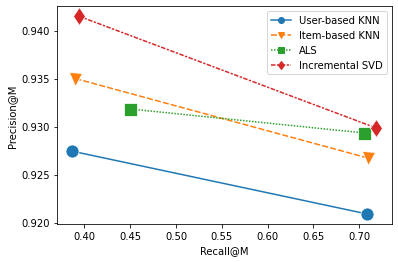

In [ ]:
p = sns.lineplot(x='Recall@M', y='Precision@M', hue='Algorithm', 
                 style='Algorithm', markers=['o','v','s','d'], data=p_and_r_df, markersize=13)
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], loc=1)

p.get_figure().savefig('Precision_Recall_Tradeoff.png', dpi=1000)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, dpi=1000)
plt.subplots_adjust(right=2, top=1, left=0)

sns.lineplot(x='M', y='F1@M', hue='Algorithm', style='Algorithm', markers=['o','v','s','d'], data=p_and_r_df, ax=ax1)
sns.lineplot(x='Recall@M', y='Precision@M', hue='Algorithm', style='Algorithm', markers=['o','v','s','d'], data=p_and_r_df, ax=ax2)

# remove label
for ax in (ax1, ax2):
  handles, labels = ax.get_legend_handles_labels()
  ax.legend(handles=handles[1:], labels=labels[1:], loc=1)

**The result** illustrated in Fig.X is measured by using each model to predict the rating of all users on the items they rated in the test set. 

The distance between the result of four algorithms is not too far. The accuracy seems to be very good because all are approximately in the range between 0.9375 and 0.9175. The trade-off between the precision and recall is high for Item-based KNN and SVD models, and low for User-based KNN and ALS models.Amongst all, the most well perform model is the SVD model, however, the trade-off is high when we increase the numbr of K. As expected, the Recall@K increases when K increases since we are increasing the numerator of the Recall@K while keeping the donimator fixed. While the Recall@K increases, the Precision@K decreases, once again, we can see the trade-off clearly.

In [ ]:
fig.savefig('Precision_Recall_final.png', dpi=1000)

### HIT RATE

In [ ]:
svd_recsys = RecSys(DRIVE_PATH + '/model/funk-svd') 

In [ ]:
from collections import defaultdict
def get_hit_rate(recsys, n, use_xquad=False):
  if use_xquad:
    n = n*2
    short_items, long_items = recsys.get_short_head_and_long_tail_items(threshold=3)

  test_set = recsys.get_testset()
  test_users = test_set['u_id'].unique().tolist()
  test_user_ratings = defaultdict(set)

  for uid, iid, true_r, est in recsys.predictions.values:
    test_user_ratings[uid].add(iid)
  
  print(f'Total users: {len(test_users)}')
  hits = []
  for i, u_id in enumerate(test_users):
    recommendation = recsys.recommend(u_id, n, exclude_test=False)

    if use_xquad:
      user_profile = recsys.get_user_profile(u_id)
      recommendation = xquad(recommendation, user_profile, short_items, long_items, recsys.trainset, n_epochs=int(n/2), reg=0.1)

    hit = sum([i in test_user_ratings[u_id] for i, _ in recommendation]) / len(recommendation)
    hits.append(hit)
    print(f'{i+1}/{len(test_users)} ====> {hit}')

  return np.mean(hits)
  

In [ ]:
controlled_hits = []
for k in range(50, 250, 50):
  controlled_hits.append(get_hit_rate(svd_recsys, k, use_xquad=True))

In [ ]:
uncontrolled_hits = []
for k in range(50, 250, 50):
  uncontrolled_hits.append(get_hit_rate(svd_recsys, k, use_xquad=False))

In [ ]:
controlled_hits

[0.001103896103896104,
 0.001064935064935065,
 0.0010692640692640692,
 0.0010454545454545456]

In [ ]:
uncontrolled_hits

[0.0012207792207792206,
 0.0011623376623376624,
 0.0011385281385281386,
 0.0010681818181818182]

In [ ]:
n = 250
uncontrolled = [(i*100, 'uncontrolled', n-(50*(index+1))) for index, i in enumerate(uncontrolled_hits)]
controlled = [(i*100, 'controlled', n-(50*(index+1))) for index, i in enumerate(controlled_hits)]

In [ ]:
controlled

[(0.1103896103896104, 'controlled', 200),
 (0.1064935064935065, 'controlled', 150),
 (0.10692640692640693, 'controlled', 100),
 (0.10454545454545455, 'controlled', 50)]

In [ ]:
hit_rate_df = pd.DataFrame(controlled + uncontrolled, columns=['Average Hit Rate', 'type', 'Choice of M'])

In [ ]:
hit_rate_df.to_csv(DRIVE_PATH + '/data/dataframe/HitRate.csv', index=False)

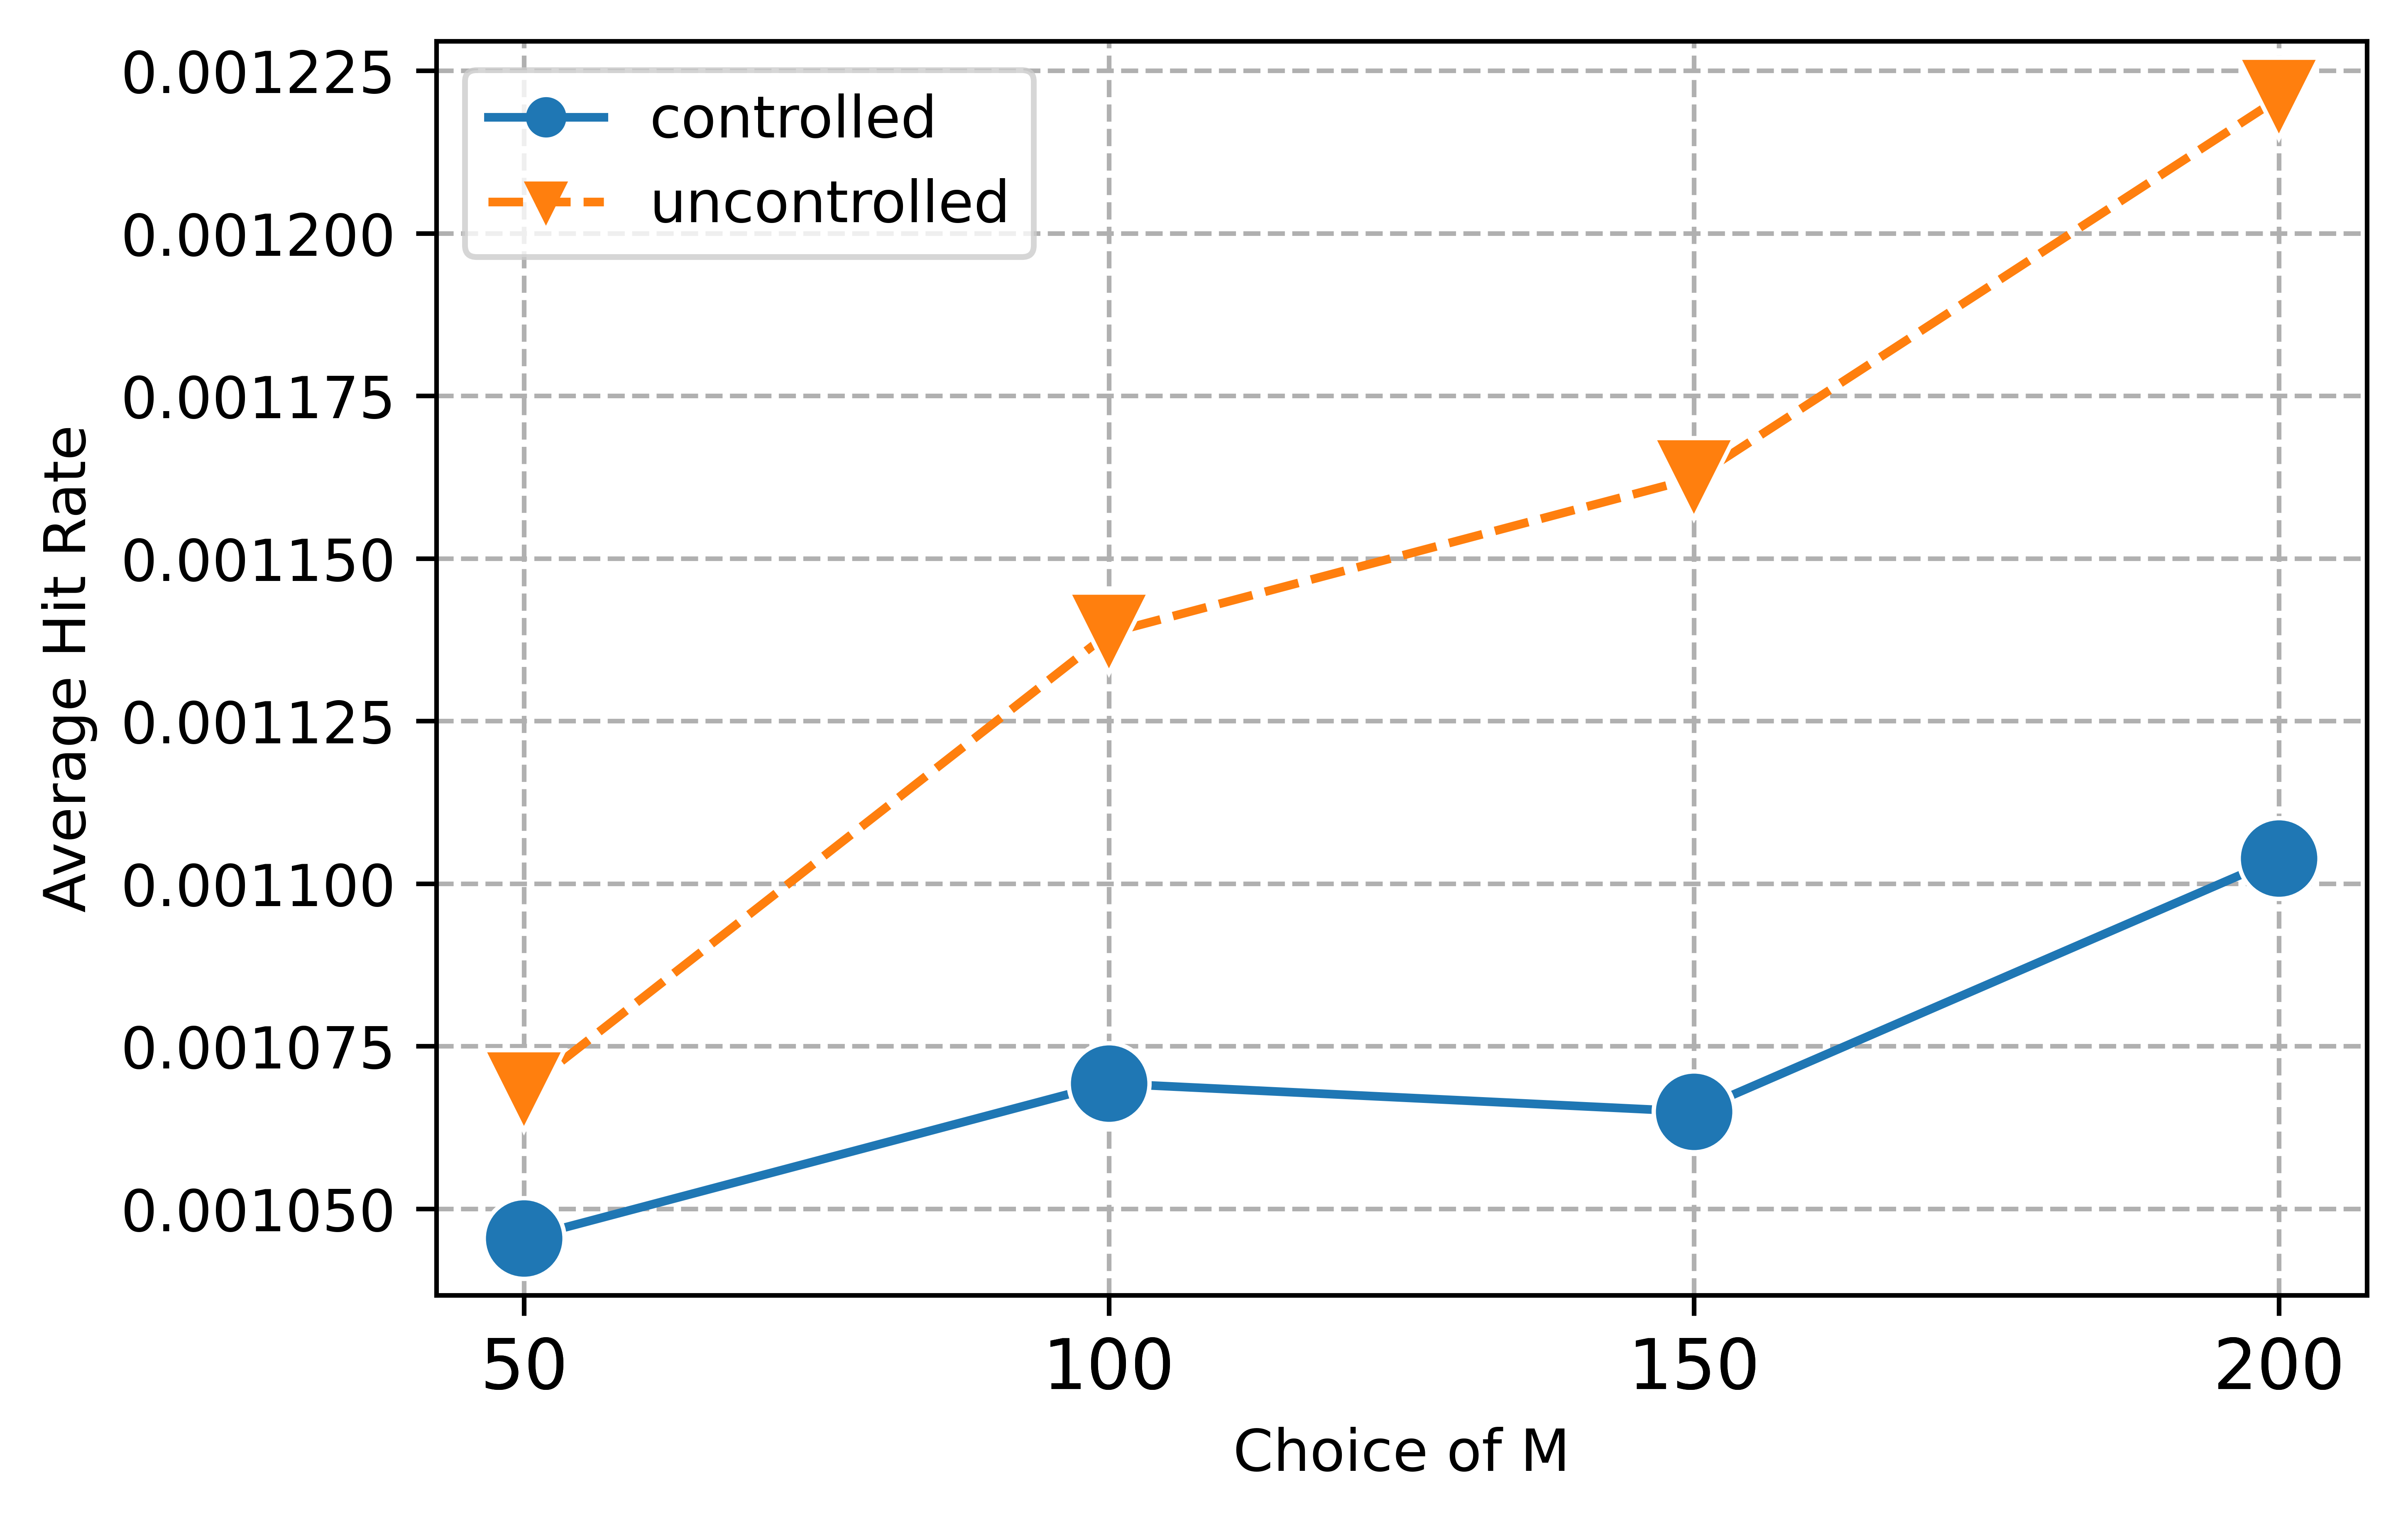

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(dpi=1000)
ax = plt.gca()

p = sns.lineplot(x='Choice of M',y='Average Hit Rate', hue='type', style='type', markers=['o','v'], data=hit_rate_df, markersize=14)
handles, labels = ax.get_legend_handles_labels()
ax.set_xticks(hit_rate_df['Choice of M']) 
ax.set_xticklabels(hit_rate_df['Choice of M'], fontsize=12)
ax.legend(handles=handles[1:], labels=labels[1:])
ax.grid(True, linestyle='--')

p.get_figure().savefig('HitRate', dpi=500)